In [1]:
!pip install tensorflow
!pip install keras

! pip install numpy scipy

# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на отмасштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential

Using TensorFlow backend.


## Загрузка и первичный анализ данных

Используем данные из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [3]:
# Будем использовать только обучающую выборку
data = pd.read_csv('train.csv', sep=",")

In [4]:
# размер набора данных
data.shape

(1460, 81)

In [5]:
# типы колонок
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [6]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [7]:
# Первые 5 строк датасета
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 1460


# 1. Обработка пропусков в данных

## 1.1. Простые стратегии - удаление или заполнение нулями

In [9]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((1460, 81), (1460, 62))

In [10]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((1460, 81), (0, 81))

In [11]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000


## 1.2. "Внедрение значений" - импьютация (imputation)

### 1.2.1. Обработка пропусков в числовых данных

In [13]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка LotFrontage. Тип данных float64. Количество пустых значений 259, 17.74%.
Колонка MasVnrArea. Тип данных float64. Количество пустых значений 8, 0.55%.
Колонка GarageYrBlt. Тип данных float64. Количество пустых значений 81, 5.55%.


In [14]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,LotFrontage,MasVnrArea,GarageYrBlt
0,65.0,196.0,2003.0
1,80.0,0.0,1976.0
2,68.0,162.0,2001.0
3,60.0,0.0,1998.0
4,84.0,350.0,2000.0
5,85.0,0.0,1993.0
6,75.0,186.0,2004.0
7,NaN,240.0,1973.0
8,51.0,0.0,1931.0
9,50.0,0.0,1939.0


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


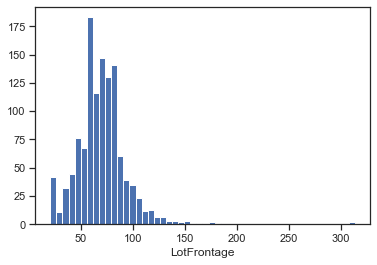

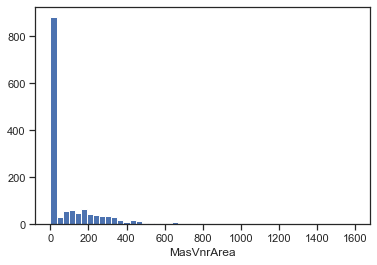

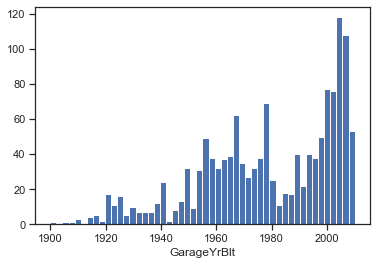

In [15]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [16]:
# Фильтр по пустым значениям поля MasVnrArea 
data[data['MasVnrArea'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


In [17]:
# Запоминаем индексы строк с пустыми значениями
flt_index = data[data['MasVnrArea'].isnull()].index
flt_index

Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')

In [18]:
# Проверяем что выводятся нужные строки
data[data.index.isin(flt_index)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


In [19]:
# фильтр по колонке
data_num[data_num.index.isin(flt_index)]['MasVnrArea']

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html#impute

In [20]:
data_num_MasVnrArea = data_num[['MasVnrArea']]
data_num_MasVnrArea.head()

,MasVnrArea
0,196.0
1,0.0
2,162.0
3,0.0
4,350.0


In [21]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [22]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_MasVnrArea)
mask_missing_values_only

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [23]:
strategies=['mean', 'median','most_frequent']

In [24]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_MasVnrArea)
    return data_num_imp[mask_missing_values_only]

In [25]:
strategies[0], test_num_impute(strategies[0])

('mean', array([103.68526171, 103.68526171, 103.68526171, 103.68526171,
        103.68526171, 103.68526171, 103.68526171, 103.68526171]))

In [26]:
strategies[1], test_num_impute(strategies[1])

('median', array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [27]:
strategies[2], test_num_impute(strategies[2])

('most_frequent', array([0., 0., 0., 0., 0., 0., 0., 0.]))

In [28]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    filled_data = data_num_imp[mask_missing_values_only]
    
    return data_num_imp

# Теперь применим это к датасету
# У нас были пропуски в 'LotFrontage', 'MasVnrArea', 'GarageYrBlt' 

In [29]:
data['LotFrontage']=test_num_impute_col(data, 'LotFrontage',strategies[1])
data[data['LotFrontage'].isnull()].shape

(0, 81)

In [30]:
data['MasVnrArea']=test_num_impute_col(data, 'MasVnrArea',strategies[0])

data['GarageYrBlt']=test_num_impute_col(data, 'GarageYrBlt',strategies[1])

### 1.2.2. Обработка пропусков в категориальных данных

In [31]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
del_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))
        if temp_perc<80:
            cat_cols.append(col)
        else:
            del_cols.append(col)

Колонка Alley. Тип данных object. Количество пустых значений 1369, 93.77%.
Колонка MasVnrType. Тип данных object. Количество пустых значений 8, 0.55%.
Колонка BsmtQual. Тип данных object. Количество пустых значений 37, 2.53%.
Колонка BsmtCond. Тип данных object. Количество пустых значений 37, 2.53%.
Колонка BsmtExposure. Тип данных object. Количество пустых значений 38, 2.6%.
Колонка BsmtFinType1. Тип данных object. Количество пустых значений 37, 2.53%.
Колонка BsmtFinType2. Тип данных object. Количество пустых значений 38, 2.6%.
Колонка Electrical. Тип данных object. Количество пустых значений 1, 0.07%.
Колонка FireplaceQu. Тип данных object. Количество пустых значений 690, 47.26%.
Колонка GarageType. Тип данных object. Количество пустых значений 81, 5.55%.
Колонка GarageFinish. Тип данных object. Количество пустых значений 81, 5.55%.
Колонка GarageQual. Тип данных object. Количество пустых значений 81, 5.55%.
Колонка GarageCond. Тип данных object. Количество пустых значений 81, 5.55%

In [32]:
cat_cols

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

### Какие из этих колонок Вы бы выбрали или не выбрали для построения модели?

In [33]:
#Можем сразу удалить те что почти полностью отсутствуют >80% пропусков
for col in del_cols:
    del data[col]


Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [34]:
cat_temp_data = data[['MasVnrType']]
cat_temp_data.head()


,MasVnrType
0,BrkFace
1,None
2,BrkFace
3,None
4,BrkFace


In [35]:
cat_temp_data['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [36]:
cat_temp_data[cat_temp_data['MasVnrType'].isnull()].shape

(8, 1)

In [37]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['BrkFace'],
       ['None'],
       ['BrkFace'],
       ...,
       ['None'],
       ['None'],
       ['None']], dtype=object)

In [38]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['BrkCmn', 'BrkFace', 'None', 'Stone'], dtype=object)

In [39]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='!!!')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['BrkFace'],
       ['None'],
       ['BrkFace'],
       ...,
       ['None'],
       ['None'],
       ['None']], dtype=object)

In [40]:
np.unique(data_imp3)

array(['!!!', 'BrkCmn', 'BrkFace', 'None', 'Stone'], dtype=object)

In [41]:
data_imp3[data_imp3=='!!!'].size

8

# Применяем вставку наиболее частых значений в категориальные признаки

In [42]:
cat_cols

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [43]:
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for col in cat_cols:
    data[col]=imp2.fit_transform(data[[col]])
    

In [44]:
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((1460, 77), (1460, 77))

# 2. Преобразование категориальных признаков в числовые

## 2.1. Кодирование категорий целочисленными значениями - [label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [45]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [46]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(data['MasVnrType'])

In [47]:
data[cat_cols[1]].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [48]:
np.unique(cat_enc_le)

array([0, 1, 2, 3])

In [49]:
le.inverse_transform([0, 1, 2, 3])

array(['BrkCmn', 'BrkFace', 'None', 'Stone'], dtype=object)

## 2.2. Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [50]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(data[['MasVnrType']])

In [51]:
data[['MasVnrType']].head(10)

,MasVnrType
0,BrkFace
1,None
2,BrkFace
3,None
4,BrkFace
5,None
6,Stone
7,Stone
8,None
9,None


In [52]:
cat_enc_ohe.shape

(1460, 4)

In [53]:
cat_enc_ohe

<1460x4 sparse matrix of type '<class 'numpy.float64'>'
	with 1460 stored elements in Compressed Sparse Row format>

In [54]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])

## 2.3. [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [55]:
pd.get_dummies(data[['MasVnrType']]).head()

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
0,0,1,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,1,0,0


In [56]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_nan
0,0,1,0,0,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0


# Теперь применяем кодирование числами к нашим категориальным признакам 

In [57]:
#Снова выбираем все категориальные колонки
cat_cols = []
for col in data.columns:
    dt = str(data[col].dtype)
    if (dt=='object'):
            cat_cols.append(col)

In [58]:
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])

In [59]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,...,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,...,0,0,0,0,0,12,2008,8,4,250000


# 3. Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины.

In [60]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## 3.1. [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [61]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['SalePrice']])

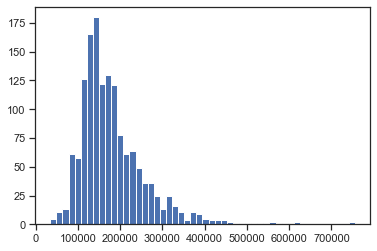

In [62]:
plt.hist(data['SalePrice'], 50)
plt.show()

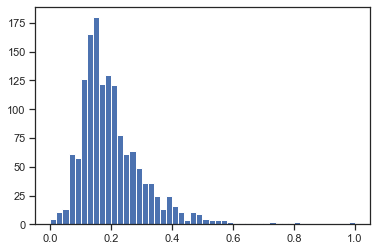

In [63]:
plt.hist(sc1_data, 50)
plt.show()

# Применяем масштабирование к датасету

In [64]:
sc1 = MinMaxScaler()
for col in data.columns:
    if col!='SalePrice':
        data[col] = sc1.fit_transform(data[[col]])

## 3.3. [Нормализация данных](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)

In [65]:
sc3 = Normalizer()
sc3_data = sc3.fit_transform(data[['SalePrice']])

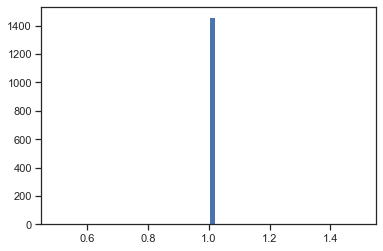

In [66]:
plt.hist(sc3_data, 50)
plt.show()

# Дополнительные источники
- [Руководство scikit-learn по предобработке данных](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Kaggle Data Cleaning Challenge: Handling missing values (упражнения с пояснениями по обработке пропущенных значений и масштабированию признаков)](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)

- [Краткое руководство по категориальным признакам](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)


In [67]:
corr=[[data.columns.values[x],  data.corr()["SalePrice"][x]] for x in range(data.shape[1])]
corr

[['Id', -0.021916719443431112],
 ['MSSubClass', -0.08428413512659473],
 ['MSZoning', -0.16687220265320576],
 ['LotFrontage', 0.3347708531397598],
 ['LotArea', 0.26384335387140534],
 ['Street', 0.04103553550004989],
 ['LotShape', -0.25557987048712133],
 ['LandContour', 0.015453241660960503],
 ['Utilities', -0.014314296147248952],
 ['LotConfig', -0.06739602315941719],
 ['LandSlope', 0.05115224817946586],
 ['Neighborhood', 0.21085146582230335],
 ['Condition1', 0.09115491154092925],
 ['Condition2', 0.007512734036332996],
 ['BldgType', -0.08559060818352893],
 ['HouseStyle', 0.18016262334399252],
 ['OverallQual', 0.7909816005837983],
 ['OverallCond', -0.0778558940486776],
 ['YearBuilt', 0.5228973328794966],
 ['YearRemodAdd', 0.5071009671113857],
 ['RoofStyle', 0.22240529240713836],
 ['RoofMatl', 0.13238311192778768],
 ['Exterior1st', 0.1035510111909052],
 ['Exterior2nd', 0.10376553702965832],
 ['MasVnrType', 0.01821577126165867],
 ['MasVnrArea', 0.4752413167736673],
 ['ExterQual', -0.6368836

In [68]:

corr.sort(key=lambda i: i[1])
corr

[['ExterQual', -0.6368836943991161],
 ['BsmtQual', -0.6180253538653172],
 ['KitchenQual', -0.5891887782994225],
 ['GarageFinish', -0.5372421226773492],
 ['HeatingQC', -0.4001775431629018],
 ['GarageType', -0.30210546284841494],
 ['BsmtExposure', -0.2954067382413881],
 ['LotShape', -0.25557987048712133],
 ['MSZoning', -0.16687220265320576],
 ['KitchenAbvGr', -0.13590737084214097],
 ['EnclosedPorch', -0.12857795792595517],
 ['Heating', -0.09881207599757688],
 ['BsmtFinType1', -0.09210633107556539],
 ['BldgType', -0.08559060818352893],
 ['MSSubClass', -0.08428413512659473],
 ['OverallCond', -0.0778558940486776],
 ['LotConfig', -0.06739602315941719],
 ['SaleType', -0.05491147712871259],
 ['YrSold', -0.0289225851687303],
 ['LowQualFinSF', -0.025606130000679354],
 ['Id', -0.021916719443431112],
 ['MiscVal', -0.021189579640302634],
 ['BsmtHalfBath', -0.016844154297359294],
 ['Utilities', -0.014314296147248952],
 ['BsmtFinSF2', -0.011378121450215233],
 ['Condition2', 0.007512734036332996],
 ['

In [69]:
def less_40(a):
    return abs(a[1])<=0.4

del_corr=list(filter(less_40, corr))

In [70]:
for i in del_corr:
    del data[i[0]]

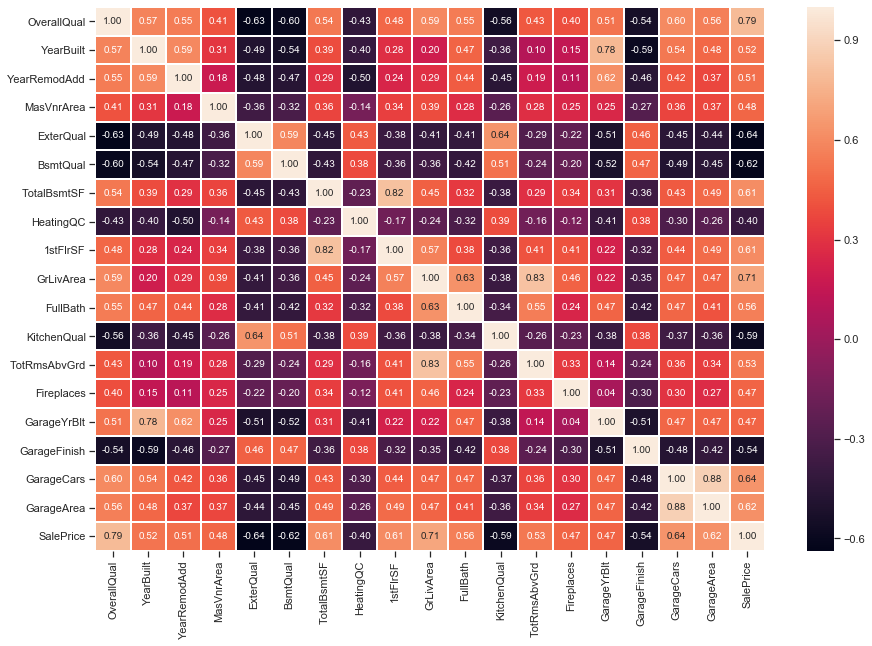

In [71]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(),annot=True, fmt='.2f', linewidths=1)

In [72]:
data.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,TotalBsmtSF,HeatingQC,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,SalePrice
0,0.666667,0.949275,0.883333,0.12250,0.666667,0.666667,0.140098,0.0,0.119780,0.259231,0.666667,0.666667,0.500000,0.000000,0.936364,0.5,0.50,0.386460,208500
1,0.555556,0.753623,0.433333,0.00000,1.000000,0.666667,0.206547,0.0,0.212942,0.174830,0.666667,1.000000,0.333333,0.333333,0.690909,0.5,0.50,0.324401,181500
2,0.666667,0.934783,0.866667,0.10125,0.666667,0.666667,0.150573,0.0,0.134465,0.273549,0.666667,0.666667,0.333333,0.333333,0.918182,0.5,0.50,0.428773,223500
3,0.666667,0.311594,0.333333,0.00000,1.000000,1.000000,0.123732,0.5,0.143873,0.260550,0.333333,0.666667,0.416667,0.333333,0.890909,1.0,0.75,0.452750,140000
4,0.777778,0.927536,0.833333,0.21875,0.666667,0.666667,0.187398,0.0,0.186095,0.351168,0.666667,0.666667,0.583333,0.333333,0.909091,0.5,0.75,0.589563,250000


In [73]:
msk = np.random.rand(len(data)) < 0.8

train=data[msk]
test=data[~msk]

y_test=test['SalePrice']
del test['SalePrice']

y_train=train['SalePrice']
del train['SalePrice']


In [74]:
def create_model(init):
    model = keras.Sequential()
    model.add(keras.layers.Dense(100, input_shape=(train.shape[1],), kernel_initializer=init, activation='sigmoid'))
    model.add(keras.layers.Dense(100, kernel_initializer=init, activation='sigmoid'))
    model.add(keras.layers.Dense(100, kernel_initializer=init, activation='sigmoid'))
    model.add(keras.layers.Dense(100, kernel_initializer=init, activation='sigmoid'))
    model.add(keras.layers.Dense(1, kernel_initializer=init, activation='linear'))
    return model

In [75]:
uniform_model = create_model("uniform")
uniform_model.compile(
loss='mean_absolute_error', optimizer=keras.optimizers.SGD(lr=0.1), metrics=['mean_absolute_percentage_error'])
uniform_model.fit(train, y_train,
batch_size=64, nb_epoch=3000, verbose=2, validation_data=(test, y_test))

Train on 1174 samples, validate on 286 samples
Epoch 1/3000
1174/1174 - 0s - loss: 180221.6204 - mean_absolute_percentage_error: 99.9679 - val_loss: 183446.1121 - val_mean_absolute_percentage_error: 99.9081
Epoch 2/3000
1174/1174 - 0s - loss: 180039.4130 - mean_absolute_percentage_error: 99.8493 - val_loss: 183253.9016 - val_mean_absolute_percentage_error: 99.7854
Epoch 3/3000
1174/1174 - 0s - loss: 179847.4184 - mean_absolute_percentage_error: 99.7237 - val_loss: 183062.0011 - val_mean_absolute_percentage_error: 99.6628
Epoch 4/3000
1174/1174 - 0s - loss: 179655.5191 - mean_absolute_percentage_error: 99.5988 - val_loss: 182870.1089 - val_mean_absolute_percentage_error: 99.5402
Epoch 5/3000
1174/1174 - 0s - loss: 179463.6201 - mean_absolute_percentage_error: 99.4738 - val_loss: 182678.1855 - val_mean_absolute_percentage_error: 99.4176
Epoch 6/3000
1174/1174 - 0s - loss: 179271.7188 - mean_absolute_percentage_error: 99.3491 - val_loss: 182486.2943 - val_mean_absolute_percentage_error: 9